In [1]:
import os
import pickle
import datetime
import numpy as np
import tensorflow as tf
import models.cifar10CNN
import models.WaveletCifar10CNN

from keras.models import Model
from models.DWT import DWT_Pooling, IWT_UpSampling

from keras.datasets import cifar10
from keras.models import model_from_json
from sklearn.model_selection import KFold
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence


Using TensorFlow backend.


In [2]:
weights_filepath = 'weights'
logs_filepath = 'logs'


if not os.path.exists(weights_filepath):
    os.makedirs(weights_filepath)

if not os.path.exists(logs_filepath):
    os.makedirs(logs_filepath)


In [3]:
nb_classes = 10
num_folds = 10
batch_size = 32
epochs = 30

lr = 1e-4  # learning rate
beta_1 = 0.9         # beta 1 - for adam optimizer
beta_2 = 0.96        # beta 2 - for adam optimizer
epsilon = 1e-7        # epsilon - for adam optimizer

trainFactor = 0.8
imageShape = (32, 32, 3)  # CIFAR-10 60,000 32X32 color


In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)  # SGD()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [7]:

# Create and Train the Model

model = models.WaveletCifar10CNN.WaveletCNN(imageShape, nb_classes)
history_file_path = "trainHistoryWaveletCifar10CNN.txt" # save loss and val loss

# model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

h5_tmp = "tmp.h5"

history = model.fit(x_train, y_train,
                    validation_split=1 - trainFactor,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    callbacks=[
                        ModelCheckpoint(h5_tmp, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                        EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
                        ],
                    )

model.load_weights(h5_tmp)
weights_path = os.path.join(weights_filepath, "WCNNN.h5")
model.save(weights_path)

# Model Evaluation
result = model.evaluate(x_test, y_test)

with open(history_file_path, 'wb') as f:
    pickle.dump(history.history, f)



Train on 40000 samples, validate on 10000 samples
Epoch 1/30
 - 29s - loss: 2.4651 - accuracy: 0.2019 - val_loss: 1.8627 - val_accuracy: 0.3168
Epoch 2/30
 - 28s - loss: 1.8321 - accuracy: 0.3211 - val_loss: 1.8983 - val_accuracy: 0.3523
Epoch 3/30
 - 28s - loss: 1.6660 - accuracy: 0.3847 - val_loss: 1.4787 - val_accuracy: 0.4679
Epoch 4/30
 - 28s - loss: 1.5728 - accuracy: 0.4267 - val_loss: 1.4187 - val_accuracy: 0.4882
Epoch 5/30
 - 28s - loss: 1.5007 - accuracy: 0.4575 - val_loss: 1.3162 - val_accuracy: 0.5222
Epoch 6/30
 - 28s - loss: 1.4361 - accuracy: 0.4810 - val_loss: 1.2578 - val_accuracy: 0.5505
Epoch 7/30
 - 28s - loss: 1.3822 - accuracy: 0.4996 - val_loss: 1.3269 - val_accuracy: 0.5276
Epoch 8/30
 - 28s - loss: 1.3352 - accuracy: 0.5204 - val_loss: 1.2108 - val_accuracy: 0.5653
Epoch 9/30
 - 28s - loss: 1.2883 - accuracy: 0.5389 - val_loss: 1.1317 - val_accuracy: 0.5978
Epoch 10/30
 - 28s - loss: 1.2484 - accuracy: 0.5548 - val_loss: 1.0915 - val_accuracy: 0.6084
Epoch 11

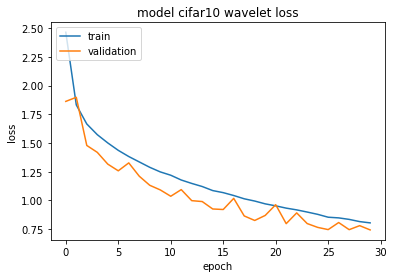

In [8]:
import pickle
import matplotlib.pyplot as plt

history_file_path = r"trainHistoryWaveletCifar10CNN.txt"

with open(history_file_path, 'rb') as pickle_file:
    history = pickle.load(pickle_file)


# plot train and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model cifar10 wavelet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()





In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,{'DWT_Pooling':DWT_Pooling})
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [11]:
# load layers from the model
layer_outputs = [layer.output for layer in loaded_model.layers][1:] # Extracts the outputs of the top layers
activation_model = Model(inputs=loaded_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(x_test) # Returns a list of Numpy arrays: one array per layer activation



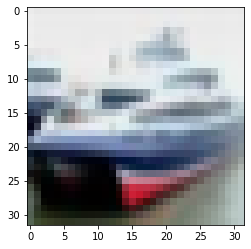

In [12]:
img_idx = 1
plt.imshow(x_test[img_idx,:,:,])
# plt.axis('off')
# for idx, act in enumerate(activations):
#     pass
    # plt.subplot(20,20,idx+1)
#     plt.imshow(act[img_idx, :, :,0], cmap='viridis')
#     plt.axis('off')
    

In [13]:
# fig, ax = plt.subplots(4)

# for i in range(4):
#     ax[i].imshow(act[img_idx, :, :,i])
# #     plt.imshow(act[img_idx, :, :,i])

In [14]:
len(activations)


24

In [15]:
activations[22].shape

(10000, 512)

In [16]:
activation_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0   